# Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
from sklearn.base import clone
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

# Data

https://www.kaggle.com/datasets/hwwang98/software-usage-promotion-campaign-uplift-model

In [19]:
raw = pd.read_csv('~/Desktop/projects/datasets/software_usage_promotion_campaign.csv')
raw

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.363000
1,0,0,1,1,20842,107,70,159038,0,1,14981.435590
2,0,0,0,1,82171,10,7,264935,1,1,32917.138940
3,0,0,0,0,30288,40,39,77522,1,1,14773.768550
4,0,0,1,0,25930,37,43,91446,1,1,17098.698230
...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,1,46186,74,48,141579,0,1,13930.128620
1996,0,0,1,0,39683,12,13,111848,0,0,4753.072214
1997,0,1,0,0,4195,14,17,11924,0,0,2161.745939
1998,1,0,0,1,10664,68,47,40037,1,1,17694.820790


For this task we will look at the treatment effect of discount on revenue.  Possible nuiance variables are likely the size of the company (i.e. a larger company can afford to purchase more software and thus higher revenue but not necessarily because of the discount).

So is it still worth it to give big companies discounts?

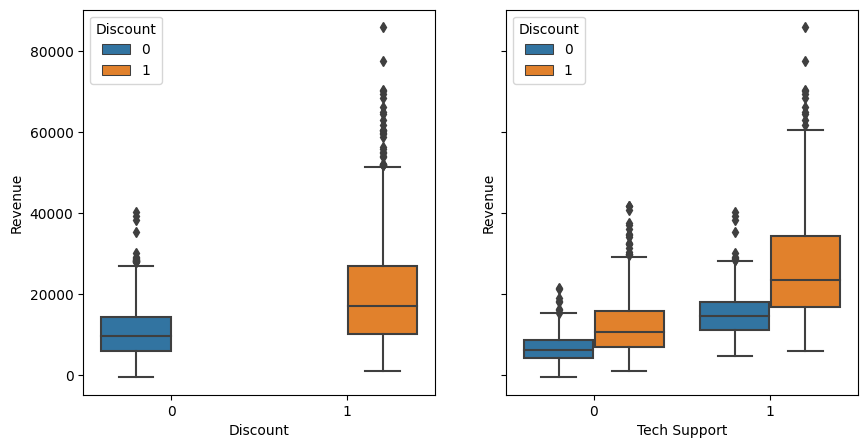

In [3]:
# Possible interventions
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
g1 = sns.boxplot(raw, x='Discount', y='Revenue', hue='Discount', ax=ax[0])
g2 = sns.boxplot(raw, x='Tech Support', y='Revenue', hue='Discount', ax=ax[1])

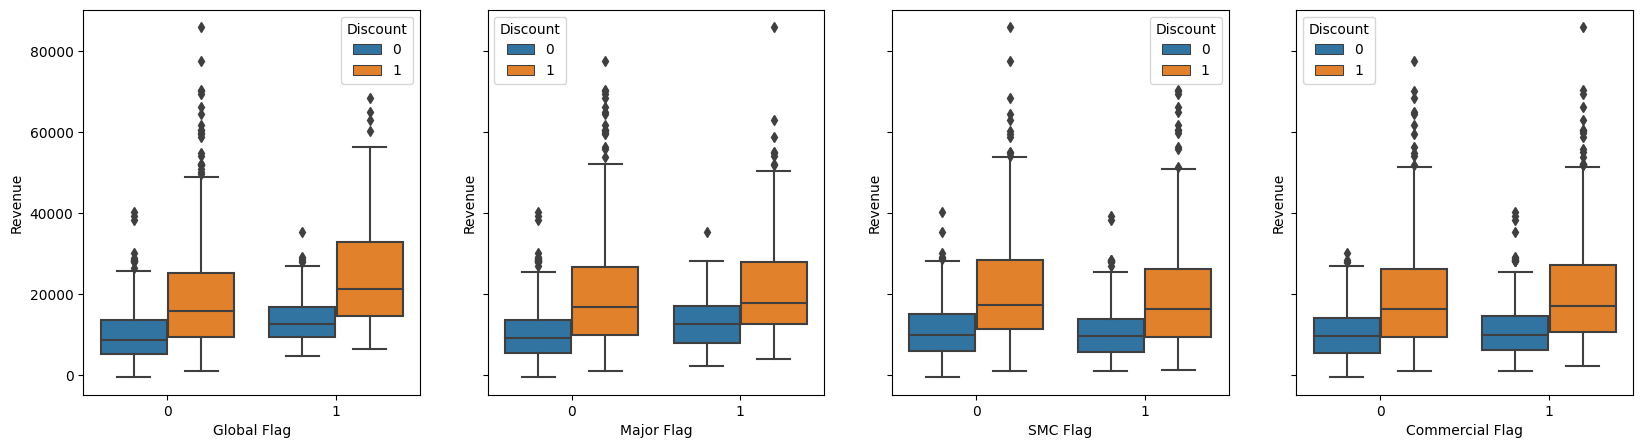

In [4]:
# Categorical 
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

g1 = sns.boxplot(raw, x='Global Flag', y='Revenue', hue='Discount', ax=ax[0])
g2 = sns.boxplot(raw, x='Major Flag', y='Revenue', hue='Discount', ax=ax[1])
g3 = sns.boxplot(raw, x='SMC Flag', y='Revenue', hue='Discount', ax=ax[2])
g4 = sns.boxplot(raw, x='Commercial Flag', y='Revenue', hue='Discount', ax=ax[3])

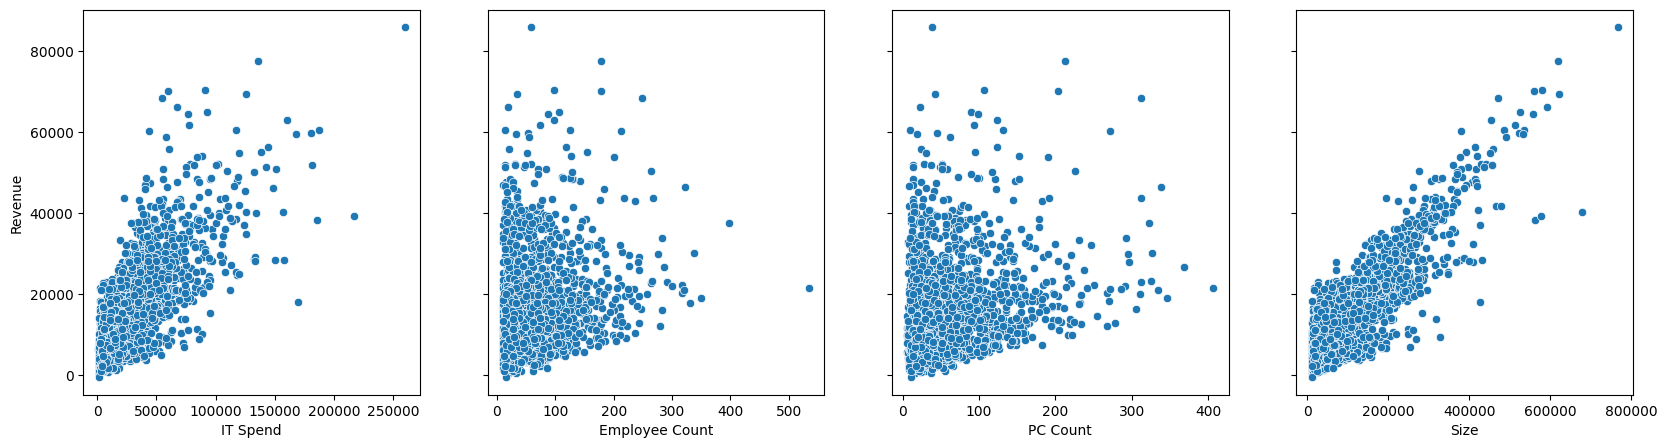

In [5]:
# Numerical
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

g1 = sns.scatterplot(data=raw, x='IT Spend', y='Revenue', ax=ax[0])
g2 = sns.scatterplot(data=raw, x='Employee Count', y='Revenue', ax=ax[1])
g3 = sns.scatterplot(data=raw, x='PC Count', y='Revenue', ax=ax[2])
g4 = sns.scatterplot(data=raw, x='Size', y='Revenue', ax=ax[3])

In [17]:
raw.groupby(['Discount'])['Revenue'].mean().diff()

Discount
0            NaN
1    9387.250919
Name: Revenue, dtype: float64

# Prepare Features

Rename columns and identify categorical vs numerical features.

In [7]:
# Create polynomial 2 terms
# poly_features = raw[['Employee Count', 'PC Count', 'Size']]**2
# poly_features.columns=['employee_2', 'pc_2', 'size_2']
# poly_features

# data = pd.concat([raw, poly_features], axis=1)

# Fix column names
data = raw.copy()
data.columns = [c.lower().replace(' ', '_') for c in data.columns]
data.head()

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [8]:
categorical_features = ['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'tech_support']
numerical_features = ['it_spend', 'employee_count', 'pc_count', 'size']

In [77]:
# Convert categorical variables
# convert_dict = {i:'object' for i in categorical_features} | {i:'float' for i in numerical_features}
# data = data.astype(convert_dict)

# Average Treatment Effect

In [9]:
y = "revenue"
d = "discount"
X = list(data.columns[~data.columns.isin([y, d])])

# Machine learning models
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)
# debias_m = LinearRegression()
# denoise_m = LinearRegression()

# Get residuals for y and T
data_pred = data.assign(d_res =  data[d] - cross_val_predict(debias_m, data[X], data[d], cv=5),
                          y_res =  data[y] - cross_val_predict(denoise_m, data[X], data[y], cv=5))

# Predict the average treatment effect 
dml_ml = smf.ols(formula='y_res ~ d_res', data=data_pred).fit()
dml_ml.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-22.2699,61.192,-0.364,0.716,-142.277,97.737
d_res,5124.0084,123.730,41.413,0.000,4881.355,5366.662


The average treatment effect (ATE) is statistically significant and much smaller than the unconditional average predictive effect (APE).

Yes, it is worth it to give large companies discounts.  On average, making $5000 more revenue.

# Linear CATE

In [10]:
y = "revenue"
d = "discount"
X = list(data.columns[~data.columns.isin([y, d])])

# Machine learning models
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
data_pred = data.assign(d_res =  data[d] - cross_val_predict(debias_m, data[X], data[d], cv=5),
                          y_res =  data[y] - cross_val_predict(denoise_m, data[X], data[y], cv=5))

# Predict the average treatment effect 
dml_ml = smf.ols(formula='y_res ~ d_res * (C(global_flag) + C(major_flag) + C(smc_flag) + C(commercial_flag) + it_spend + employee_count + pc_count + size)', data=data_pred).fit()
dml_ml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_res   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     466.3
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:41:12   Log-Likelihood:                -17676.
No. Observations:                2000   AIC:                         3.539e+04
Df Residuals:                    1982   BIC:                         3.549e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -709.6758    108.442     -6.544      0.000    -922.348    -497.004
C(global_flag)[T.1]             240.1451     93.537      2.567      0.010      56.704     423.586
C(major_flag)[T.1]              599.5466    109.328      5.484      0.000     385.138     813.956
C(smc_flag)[T.1]                288.0499     86.674      3.323      0.001     118.069     458.031
C(commercial_flag)[T.1]         293.7269     81.274      3.614      0.000     134.335     453.118
d_res                            82.9330    222.311      0.373      0.709    -353.054     518.920
d_res:C(global_flag)[T.1]        -5.2993    189.203     -0.028      0.978    -376.357     365.758
d_res:C(major_flag)[T.1]        -19.5354    220.383     -0.089      0.929    -451.743     412.672
d_res:C(smc_flag)[T.1]          -74.7884    177.211     -0.422      0.673    -422.328     272.752
d_res:C(commercial_flag)[T.1]   132.0842    164.223      0.804      0.421    -189.983     454.151
it_spend                         -0.0023      0.003     -0.831      0.406      -0.008       0.003
employee_count                   -7.0018      2.327     -3.009      0.003     -11.565      -2.439
pc_count                          9.1027      2.353      3.869      0.000       4.489      13.717
size                              0.0013      0.001      1.632      0.103      -0.000       0.003
d_res:it_spend                    0.0207      0.006      3.213      0.001       0.008       0.033
d_res:employee_count              0.7847      4.883      0.161      0.872      -8.792      10.361
d_res:pc_count                   -1.1244      4.962     -0.227      0.821     -10.855       8.606
d_res:size                        0.0433      0.002     21.940      0.000       0.039       0.047
==============================================================================
Omnibus:                      783.350   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49682.487
Skew:                           1.001   Prob(JB):                         0.00
Kurtosis:                      27.335   Cond. No.                     1.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The treatment effect is most affected by campany size (as defined by their revenue).  

# Non parametric CATE

In [93]:
y = "revenue"
d = "discount"
X = list(data.columns[~data.columns.isin([y, d])])

# Machine learning models
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# Get residuals for y and T
nonparam_pred = data.assign(d_res =  data[d] - cross_val_predict(debias_m, data[X], data[d], cv=5),
                          y_res =  data[y] - cross_val_predict(denoise_m, data[X], data[y], cv=5))

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = data_pred['d_res'] ** 2 
y_star = data_pred['y_res'] / data_pred['d_res']

non_param.fit(X=nonparam_pred[X], y=y_star.ravel(), sample_weight=w.ravel())
nonparam_pred['cate'] = non_param.predict(X=nonparam_pred[X])


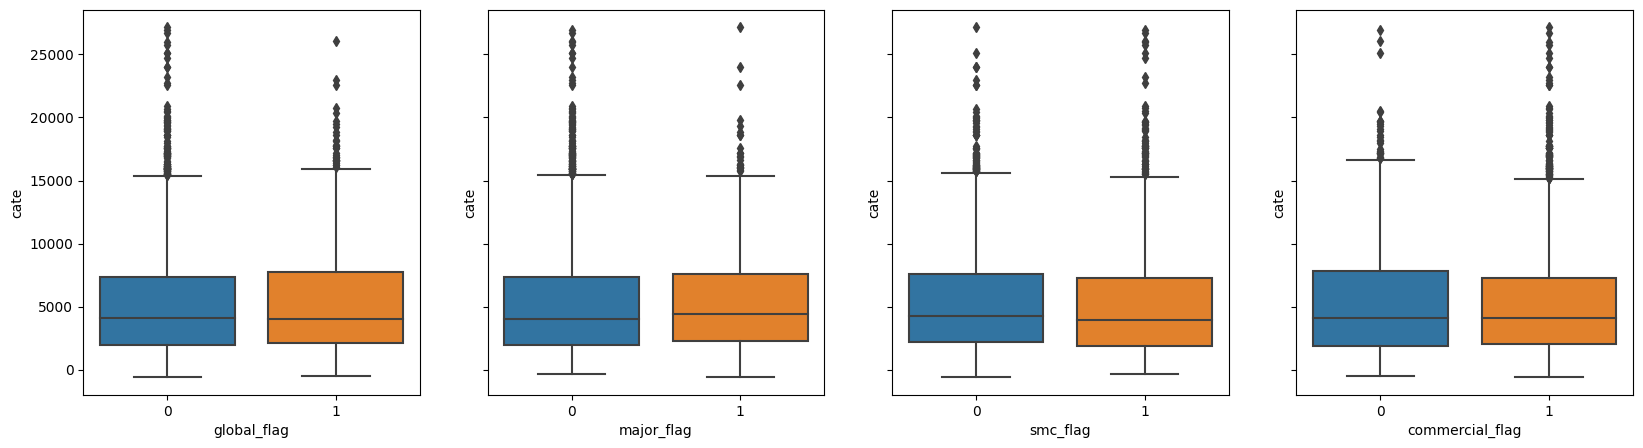

In [99]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

g1 = sns.boxplot(data=nonparam_pred, x='global_flag', y='cate', ax=ax[0])
g2 = sns.boxplot(data=nonparam_pred, x='major_flag', y='cate', ax=ax[1])
g3 = sns.boxplot(data=nonparam_pred, x='smc_flag', y='cate', ax=ax[2])
g4 = sns.boxplot(data=nonparam_pred, x='commercial_flag', y='cate', ax=ax[3])

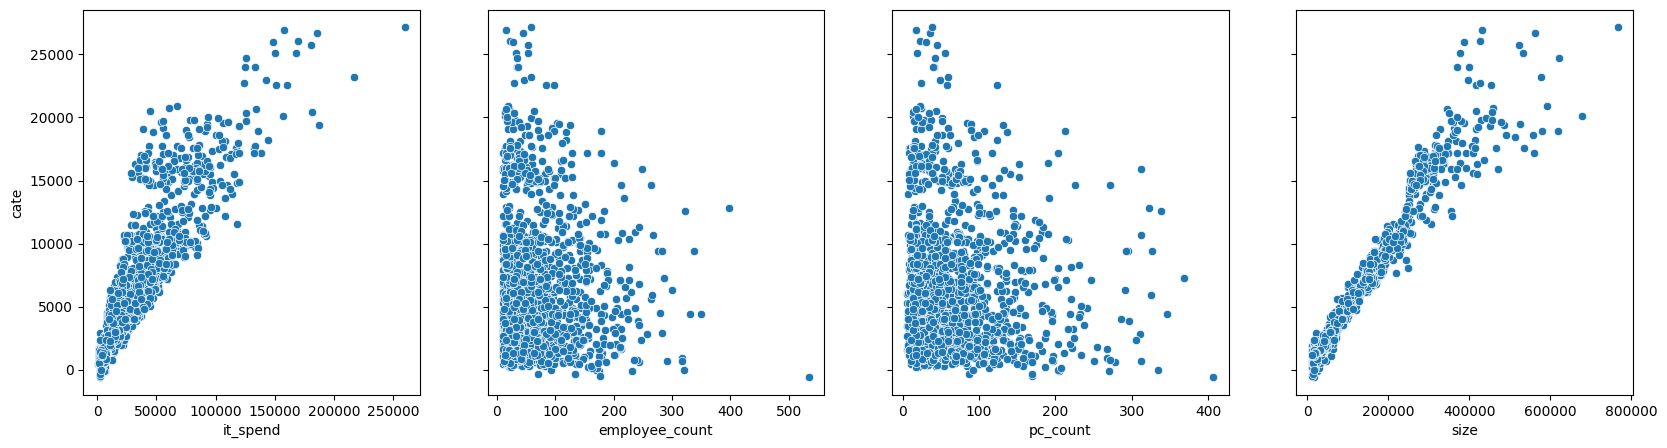

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

g1 = sns.scatterplot(data=nonparam_pred, x='it_spend', y='cate', ax=ax[0])
g2 = sns.scatterplot(data=nonparam_pred, x='employee_count', y='cate', ax=ax[1])
g3 = sns.scatterplot(data=nonparam_pred, x='pc_count', y='cate', ax=ax[2])
g4 = sns.scatterplot(data=nonparam_pred, x='size', y='cate', ax=ax[3])

CATE increases with `it_spend` and `size`. 

# End